In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

MODEL_NAME = "google-bert/bert-base-multilingual-cased"

In [2]:
config_df = pd.read_csv("mbert_indo.csv")
epoch_df = pd.read_csv("mbert_indo_epoch.csv")
epoch_df.head()
config_df.head(10)

,config_id,type_test,model_name,pooling_type,batch_size,epochs,learning_rate,attention_dropout,hidden_dropout,classifier_dropout,weight_decay,training_time,peak_memory,test_mse,test_mae,test_rmse,test_pearson
0,0,before balancing,google-bert/bert-base-multilingual-cased,cls,16,12,0.00002,0,0,0.1,0.01,1255.265903,6996.725098,0.011820,0.087100,0.108720,0.915951
1,1,before balancing,google-bert/bert-base-multilingual-cased,mean,16,23,0.00002,0,0,0.1,0.01,2367.021535,6996.725098,0.015056,0.100177,0.122703,0.916937
2,2,before balancing,google-bert/bert-base-multilingual-cased,max,16,10,0.00002,0,0,0.1,0.01,1032.569652,6996.725098,0.025846,0.132834,0.160767,0.914850
3,3,before balancing,google-bert/bert-base-multilingual-cased,attention,16,10,0.00002,0,0,0.1,0.01,1044.603534,6996.725098,0.014388,0.095823,0.119949,0.917667


# Training Plot

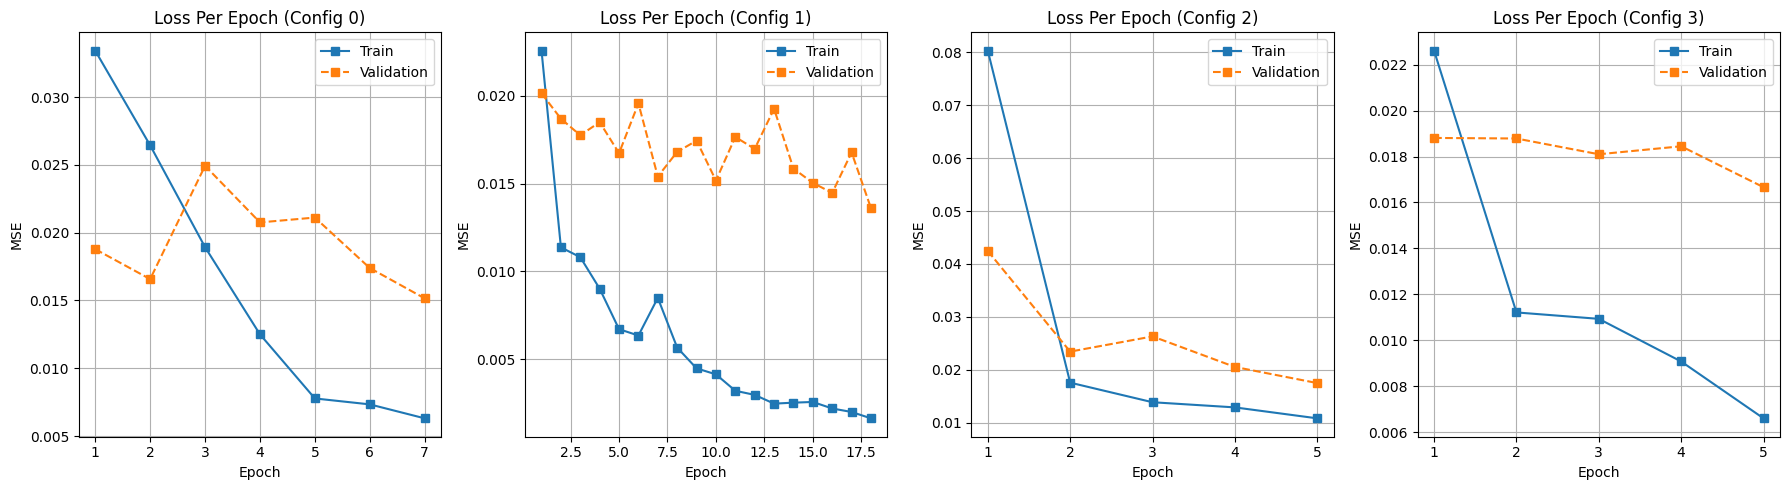

In [3]:
metrics = ['mse']
titles = {
    'mse': 'Loss Per Epoch'
}

fig, axes = plt.subplots(1, 4, figsize=(18, 5)) 

for i, row in enumerate(config_df.itertuples(index=False)):
    
    config_id = row.config_id
    data = epoch_df[epoch_df['config_id'] == config_id]
    
    epochs = data['epoch'].iloc[:-5]
    
    for metric in metrics:
        train_metric = data[f'train_{metric}'].iloc[:-5]
        valid_metric = data[f'valid_{metric}'].iloc[:-5]

        ax = axes[i]
        ax.plot(epochs, train_metric, linestyle='-', marker='s', label='Train')
        ax.plot(epochs, valid_metric, linestyle='--', marker='s', label='Validation')
        
        ax.set_title(f"{titles[metric]} (Config {config_id})")
        ax.set_xlabel("Epoch")
        ax.set_ylabel(metric.upper())
        ax.legend()
        ax.grid(True)

plt.tight_layout()
plt.show()


In [4]:
import sys
import os
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..', '..'))
sys.path.append(src_path)
from transformers import BertTokenizer
from main_regression import RegressionModel, AutomaticScoringDataset
from torch.utils.data import DataLoader
import torch

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
def predict(df_test, config_id, model):
    test_data = AutomaticScoringDataset(df_test, tokenizer)
    test_dataloader = DataLoader(test_data, batch_size=16, shuffle=False, generator=torch.Generator().manual_seed(42), num_workers=0)
    
    checkpoint = torch.load(f"../../../models/pooling/cross/mbert_indo_{config_id}.pt", map_location='cuda', weights_only=True)
    model.load_state_dict(checkpoint)
    model.eval()
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for batchs in test_dataloader:
            try:
                # move to device
                batchs = {k: v.to('cuda') for k, v in batchs.items()}
                predictions = model(
                    batchs['input_ids'], 
                    batchs['attention_mask'], 
                    batchs['token_type_ids']).squeeze(1)
                preds = torch.clamp(predictions, 0, 1)

                all_predictions.extend(preds.detach().cpu().numpy())
                all_targets.extend(batchs['labels'].detach().cpu().numpy())
            except Exception as e:
                torch.cuda.empty_cache()

    return all_predictions, all_targets

def save_predictions(df_test, output_path):
    columns_to_keep = ['question', 'reference_answer', 'answer', 'normalized_score', 'dataset_num']
    columns_to_keep += [col for col in df_test.columns if col.startswith("predicted_score_")]
    df_test = df_test[columns_to_keep]
    df_test.to_csv(output_path, index=False)

In [5]:
import pandas as pd

df_test = pd.read_csv("../../../../data/clean/cross/test_indo.csv")
for row in config_df.itertuples():
    model = RegressionModel(MODEL_NAME, pooling_type=row.pooling_type).to('cuda')
    all_predictions, all_targets = predict(df_test, row.config_id, model)

    df_test[f"predicted_score_{row.config_id}"] = all_predictions

output_dir = "inference"
os.makedirs(output_dir, exist_ok=True)

save_predictions(df_test, os.path.join(output_dir, "mbert_predictions_indo.csv"))

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
c:\Users\User\Documents\Code\env\lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always


>> CLS Pooling - predicted_score_0
RMSE: 0.1087, Pearson: 0.9160

>> Mean Pooling - predicted_score_1
RMSE: 0.1227, Pearson: 0.9169

>> Max Pooling - predicted_score_2
RMSE: 0.1590, Pearson: 0.9138

>> Attention Pooling - predicted_score_3
RMSE: 0.1199, Pearson: 0.9177


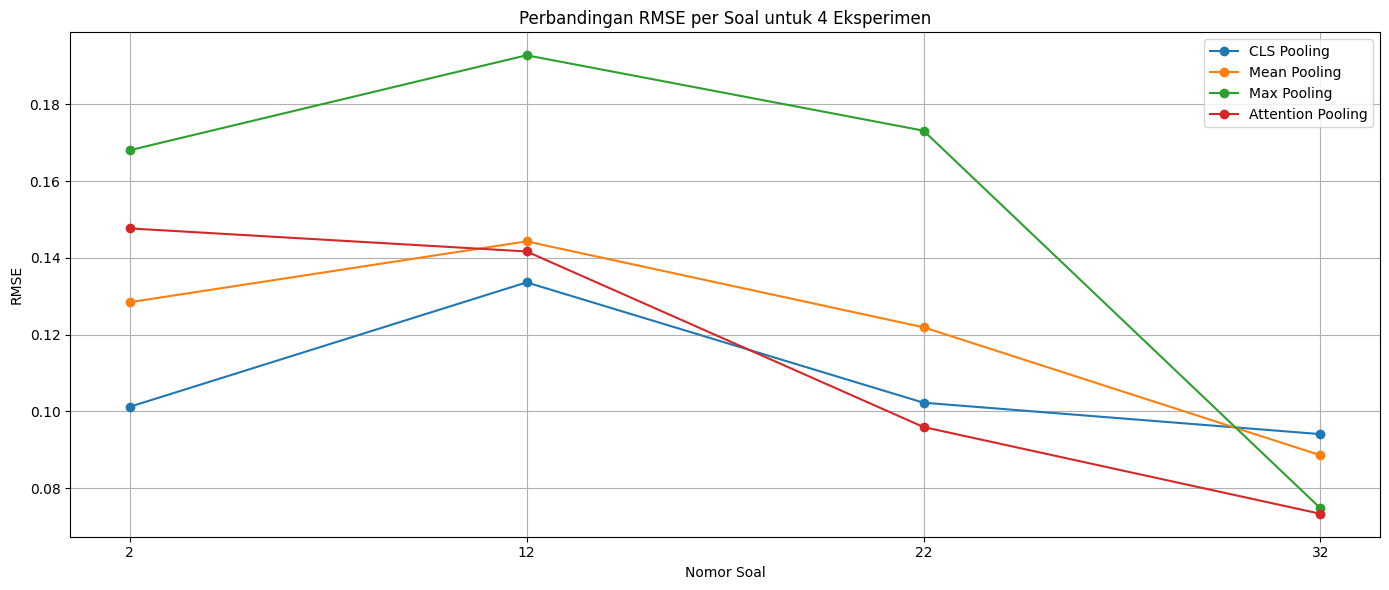

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from scipy.stats import pearsonr
from tabulate import tabulate

inference_dir = "inference"
csv_files = [f for f in os.listdir(inference_dir) if f.startswith("mbert")]

color_palette = plt.get_cmap("tab10") 

label_map = {
    "predicted_score_0": "CLS Pooling",
    "predicted_score_1": "Mean Pooling",
    "predicted_score_2": "Max Pooling",
    "predicted_score_3": "Attention Pooling",
}

rmse_per_model = {}
metric_eval_data = {}
model_idx = 0
for file in csv_files:
    file_path = os.path.join(inference_dir, file)
    df = pd.read_csv(file_path)

    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]

    for col in pred_cols:
        pred_scores = df[col].values
        residuals = pred_scores - true_scores

        rmse = root_mean_squared_error(true_scores, pred_scores)
        pearson, _ = pearsonr(true_scores, pred_scores)

        label = label_map.get(col, col) 
        print(f"\n>> {label} - {col}")
        print(f"RMSE: {rmse:.4f}, Pearson: {pearson:.4f}")

        metric_eval_data[label] = {
            "RMSE": round(rmse, 4),
            "Pearson": round(pearson, 4)
        }

        rmse_per_soal = df.groupby('dataset_num').apply(lambda x: root_mean_squared_error(x['normalized_score'], x[col]), include_groups=False)
        rmse_per_model[label] = rmse_per_soal
        model_idx += 1

def extract_soal_number(index_series):
    return index_series.astype(str).str.extract(r'(\d+)$').astype(int)[0]

plt.figure(figsize=(14, 6))
for i, label in enumerate(rmse_per_model):
    rmse_series = rmse_per_model[label]
    
    soal_numbers = extract_soal_number(rmse_series.index)
    
    rmse_series.index = soal_numbers
    rmse_series = rmse_series.sort_index()
    
    plt.plot(rmse_series.index, rmse_series.values, marker='o', linestyle='-', label=label)

plt.title("Perbandingan RMSE per Soal untuk 4 Eksperimen")
plt.xlabel("Nomor Soal")
plt.ylabel("RMSE")
plt.grid(True)
plt.legend()
plt.xticks(ticks=sorted(rmse_series.index.unique())) 
plt.tight_layout()
plt.show()



In [7]:
fixed_threshold = 0.1

model_data = []

for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]

    for col in pred_cols:
        pred_scores = df[col].values
        residuals = pred_scores - true_scores
        label = label_map.get(col, col)
        model_data.append((label, true_scores, pred_scores, residuals))

num_models = len(model_data)
outlier_count = {}
for i, (label, true_scores, pred_scores, residuals) in enumerate(model_data):
    outlier_fixed2 = np.abs(residuals) > 0.2
    outlier_fixed = np.abs(residuals) > fixed_threshold

    num_outliers_fixed2 = np.sum(outlier_fixed2)
    num_outliers_fixed = np.sum(outlier_fixed)

    print(f"{label}:")
    print(f"  Outlier (Fixed ±0.2): {num_outliers_fixed2}")
    print(f"  Outlier (Fixed ±{fixed_threshold}): {num_outliers_fixed}\n")

CLS Pooling:
  Outlier (Fixed ±0.2): 10
  Outlier (Fixed ±0.1): 76

Mean Pooling:
  Outlier (Fixed ±0.2): 13
  Outlier (Fixed ±0.1): 96

Max Pooling:
  Outlier (Fixed ±0.2): 51
  Outlier (Fixed ±0.1): 114

Attention Pooling:
  Outlier (Fixed ±0.2): 22
  Outlier (Fixed ±0.1): 85

